### 데이터 다운 & 불러오기

In [ ]:
# 데이터 다운로드 링크로 데이터를 코랩에 불러옵니다.

!wget 'https://bit.ly/3gLj0Q6'

import zipfile
with zipfile.ZipFile('3gLj0Q6', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-08-05 05:07:44--  https://bit.ly/3gLj0Q6
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E [following]
--2021-08-05 05:07:44--  https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E
Resolving drive.google.com (drive.google.com)... 142.250.128.100, 142.250.128.113, 142.250.128.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.128.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cbs66fotcj55js3d3orbc8m05t9sc50h/1628140050000/17946651057176172524/*/1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E?e=download [following]
--2021-08-05 05:07:44--  https://doc-0c-10-docs.googleusercontent.com/docs/secur

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
train=pd.read_csv('/content/data/train.csv')
test=pd.read_csv('/content/data/test.csv')

### 다양한 결측치 대체

In [ ]:
#결측치 처리를 위해 학습 데이터 세트와 타겟 값 분리
X_data=train.drop('count',axis=1)
Y_data=train['count']
X_data.shape, Y_data.shape

((1459, 10), (1459,))

In [ ]:
X_data.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
dtype: int64

##### 결측치 시각화
* hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5에 많은 결측치가 있다.   

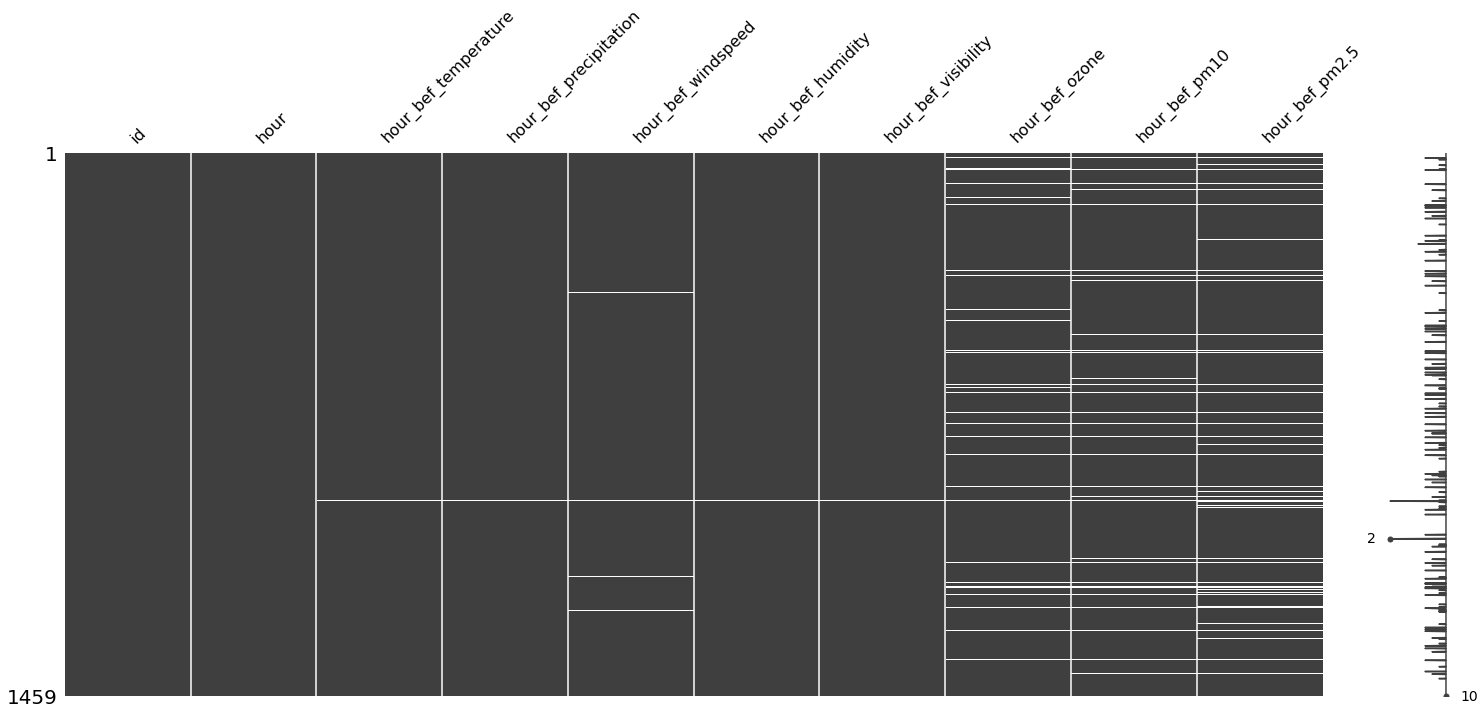

In [ ]:
import missingno as msno
msno.matrix(X_data)

* 다중 대체 방법과 knn기반 대체를 실행해 보자.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

mses=np.zeros(3)

#impouter에 따라 mse를 반환해주는 함수 작성
def get_scores_for_imputer(imputer,X_data,Y_data):
  estimator = make_pipeline(imputer,lgbm)
  impute_scores = cross_val_score(estimator, X_data, Y_data,
                                    scoring='neg_mean_squared_error',
                                    cv=5)
  return impute_scores

lgbm=LGBMRegressor()

* knn-imputation 함수 작성

In [ ]:
def get_impute_knn_score(X_data,Y_data):
  imputer=KNNImputer(missing_values=np.nan,add_indicator=True)
  knn_impute_scores=get_scores_for_imputer(imputer,X_data,Y_data)
  return knn_impute_scores.mean()


mses[0]=get_impute_knn_score(X_data,Y_data)

* iterativeImputer 함수 작성

In [ ]:
def get_impute_iterative(X_data,Y_data):
    imputer = IterativeImputer(missing_values=np.nan, add_indicator=True, random_state=0, n_nearest_features=5, sample_posterior=True)
    iterative_impute_scores = get_scores_for_imputer(imputer, X_data,Y_data)
    return iterative_impute_scores.mean()
  
mses[1]=get_impute_iterative(X_data,Y_data)

* 시간 별로 평균값 대체 함수 작성

In [ ]:
def get_impute_mean(X_data,Y_data):
  X_data[X_data['hour']==1]=X_data[X_data['hour']==1].fillna({'hour_bef_ozone':np.mean([0.033763,0.030492]),
                                'hour_bef_pm10':np.mean([55.881356,58.475410]),
                                'hour_bef_pm2.5':np.mean([30.982759,31.366667])})
  X_data=X_data.groupby('hour').apply(lambda x: x.fillna(x.mean()))
  index=[index[1] for index in X_data.index.tolist()]
  X_data.index=index
  X_data=X_data.sort_index()
  impute_scores = cross_val_score(lgbm, X_data, Y_data,
                                    scoring='neg_mean_squared_error',
                                    cv=5)
  return impute_scores.mean()

mses[2]=get_impute_mean(X_data,Y_data)

* 결과 Iteratine Imputation의 성능이 가장 좋음

In [ ]:
x_labels = ['KNN Imputation',
            'Iterative Imputation',
            'mean Imputation']
for index,x_label in enumerate(x_labels):
  print('### '+x_label+'의 mse:'+str(-mses[index]))

### KNN Imputation의 mse:1595.4796927123639
### Iterative Imputation의 mse:1582.037099323576
### mean Imputation의 mse:1595.0224245436475


### 학습 데이터+ 테스트 데이터 결측치 대체
* 위의 결과를 바탕으로 Iterative Imputation으로 결측치 대체

In [96]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [98]:
all_data=pd.concat([train,test],ignore_index=True)
all_data=all_data.drop('count',axis=1)
all_data.shape

(2174, 10)

In [110]:
#결측치 대체
imputer = IterativeImputer(missing_values=np.nan, random_state=0, n_nearest_features=5, sample_posterior=True)
all_data_transform=pd.DataFrame(imputer.fit_transform(all_data),columns=all_data.columns)
all_data_transform.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

#### 학습/예측 수행

In [112]:
#학습 데이터와 테스트 데이터 분리
train=all_data_transform.iloc[:1459,:]
test=all_data_transform.iloc[1459:,:]
train.shape, test.shape

((1459, 10), (715, 10))

In [126]:
#학습 수행
lgbm.fit(train,target)
pred=lgbm.predict(test)

submission=pd.read_csv("/content/data/submission.csv")
submission['count']=pred
submission.head()
#submission.to_csv('/content/drive/MyDrive/submission_02.csv',index=False)

,id,count
0,0,88.801541
1,1,200.045428
2,2,15.019371
3,4,30.393304
4,5,12.532832
